In [1]:
import csv
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

RANDOM_SEED = 42

In [2]:
dataset_test = 'glove_data_test/glove_test_data.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier_glove.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier_glove.tflite'

In [12]:
def augment_data_with_noise(data, noise_scale):
    column_stats = data[:, 1:].mean(axis=0), data[:, 1:].std(axis=0)

    noise = np.random.normal(loc=0, scale=column_stats[1] * noise_scale, size=data[:, 1:].shape)

    augmented_data = data.copy()
    augmented_data[:, 1:] += noise

    return augmented_data

directory = 'data_glove'

# Initialize an empty list to store data from all files
data_X = []
data_y = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Load data from each file and append to the list
        data_X.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151))))
        data_y.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=(0)))

# Concatenate data from all files along the first axis
X_dataset = np.concatenate(data_X, axis=0)
y_dataset = np.concatenate(data_y, axis=0)

# Augment data with noise
augmented_data = augment_data_with_noise(X_dataset, 0.1)
augmented_data2 = augment_data_with_noise(X_dataset, 0.01)
augmented_data3 = augment_data_with_noise(X_dataset, 0.005)
augmented_data4 = augment_data_with_noise(X_dataset, 0.05)

X_dataset = np.concatenate([X_dataset, augmented_data, augmented_data2, augmented_data3, augmented_data4], axis=0)
print(X_dataset.shape)

y_dataset = np.concatenate([y_dataset, y_dataset, y_dataset, y_dataset, y_dataset], axis=0)
print(y_dataset.shape)
X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)
X_test = np.loadtxt(dataset_test, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151)))
y_test = np.loadtxt(dataset_test, delimiter=',', dtype='int32', usecols=(0))

(120000, 172)
(120000,)


In [11]:
NUM_CLASSES = 24

In [5]:
# Directory containing CSV files
directory = 'data_glove'

# Initialize an empty list to store data from all files
data_X = []
data_y = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Load data from each file and append to the list
        data_X.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151))))
        data_y.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=(0)))

# Concatenate data from all files along the first axis
X_dataset = np.concatenate(data_X, axis=0)
y_dataset = np.concatenate(data_y, axis=0)


X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)
X_test = np.loadtxt(dataset_test, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151)))
y_test = np.loadtxt(dataset_test, delimiter=',', dtype='int32', usecols=(0))

In [32]:
# Directory containing CSV files
directory = 'data_glove'

# Initialize an empty list to store data from all files
data_X = []
data_y = []

file_path = "data_glove/data_chadwick.csv"
# Load data from each file and append to the list
data_X.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151))))
data_y.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=(0)))

# Concatenate data from all files along the first axis
X_dataset = np.concatenate(data_X, axis=0)
y_dataset = np.concatenate(data_y, axis=0)


X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)
X_test = np.loadtxt(dataset_test, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151)))
y_test = np.loadtxt(dataset_test, delimiter=',', dtype='int32', usecols=(0))

In [33]:
print("X dataset shape: " + X_dataset.shape.__str__())
print("y dataset shape: " + y_dataset.shape.__str__())
print("----------------------------------")
print("X test dataset shape: " + X_test.shape.__str__())
print("y test dataset shape: " + y_test.shape.__str__())
print("----------------------------------")
print("X dataset train shape: " + X_train.shape.__str__())
print("y dataset train shape: " + y_train.shape.__str__())

X dataset shape: (2400, 172)
y dataset shape: (2400,)
----------------------------------
X test dataset shape: (2400, 172)
y test dataset shape: (2400,)
----------------------------------
X dataset train shape: (1680, 172)
y dataset train shape: (1680,)


In [5]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Perform feature selection
selector = SelectKBest(score_func=f_classif, k='all')
X_train_selected = selector.fit_transform(X_train, y_train)
X_validation_selected = selector.transform(X_validation)

# Get feature scores
feature_scores = selector.scores_

# Get indices of selected features
selected_indices = selector.get_support(indices=True)

# Print feature scores and their corresponding indices
for i, score in enumerate(feature_scores):
    if i in selected_indices:
        print(f"Feature {i}: Score = {score}")

Feature 0: Score = 3.4120187759399414
Feature 1: Score = 12111.4248046875
Feature 2: Score = 11181.8984375
Feature 3: Score = 7464.580078125
Feature 4: Score = 13386.1376953125
Feature 5: Score = 1792.10205078125
Feature 6: Score = 6008.39501953125
Feature 7: Score = 4237.61083984375
Feature 8: Score = 4319.64697265625
Feature 9: Score = 1884.463134765625
Feature 10: Score = 9153.0400390625
Feature 11: Score = 12981.7939453125
Feature 12: Score = 12974.5419921875
Feature 13: Score = 1161.4461669921875
Feature 14: Score = 5972.60498046875
Feature 15: Score = 21562.23828125
Feature 16: Score = 21533.890625
Feature 17: Score = 1193.714111328125
Feature 18: Score = 3573.5615234375
Feature 19: Score = 10466.830078125
Feature 20: Score = 10438.7900390625
Feature 21: Score = 1042.2913818359375
Feature 22: Score = 4308.44873046875
Feature 23: Score = 24690.263671875
Feature 24: Score = 24585.17578125
Feature 25: Score = 46.385467529296875
Feature 26: Score = 3777.7333984375
Feature 27: Score =

In [6]:
# Sort feature scores and get indices of top 50 features
top_indices = sorted(range(len(feature_scores)), key=lambda i: feature_scores[i], reverse=True)[:100]

# Extract top 50 features from X_train_selected and X_validation_selected
X_train_top50 = X_train_selected[:, top_indices]
X_validation_top50 = X_validation_selected[:, top_indices]
X_test_top50 = X_test[:, top_indices]

print(X_train_top50.shape)
print(X_validation_top50.shape)
print(X_test_top50.shape)

(13440, 100)
(5760, 100)
(2400, 100)


In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((172, 1), input_shape=(172,)),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=10),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

C:\thesis\venv\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_4 (Reshape)             │ (None, 172, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 172, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 86, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 86, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 8, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,360 (774.84 KB)

 Trainable params: 198,360 (774.84 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((172, 1), input_shape=(172,)),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=10),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [37]:
model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_5 (Reshape)             │ (None, 172, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 172, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 86, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 86, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 8, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,360 (774.84 KB)

 Trainable params: 198,360 (774.84 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((86, 2, 1), input_shape=(172, )),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 10), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_6 (Reshape)             │ (None, 86, 2, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 86, 2, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 43, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 43, 2, 64)      │        61,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 21, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 2, 128)     │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 2, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 777,944 (2.97 MB)

 Trainable params: 777,944 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

In [40]:
# Model checkpoint callback
cp_callback_test = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback_test = tf.keras.callbacks.EarlyStopping(patience=30, verbose=1)

In [41]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [42]:
# Model compilation
model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [43]:
# Model compilation
model3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [44]:

history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0574 - loss: 101.4240
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.0561 - loss: 92.1428 - val_accuracy: 0.0750 - val_loss: 5.7931
Epoch 2/1000
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0603 - loss: 28.7237
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0607 - loss: 27.8149 - val_accuracy: 0.0903 - val_loss: 4.2501
Epoch 3/1000
11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0707 - loss: 11.6248
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0685 - loss: 12.4397 - val_accuracy: 0.1458 - val_loss: 4.2336
Epoch 4/1000
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0646 - loss: 13.5026
Epoch 4: saving model to model/keypoint_classif

In [23]:
history2 = model2.fit(
    X_train,
    y_train,
    epochs = 1000,
    batch_size = 64,
    validation_data = (X_validation, y_validation),
    callbacks = [cp_callback_test, es_callback_test]
)

Epoch 1/1000
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0737 - loss: 19.3336
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.0742 - loss: 19.2415 - val_accuracy: 0.6104 - val_loss: 2.2814
Epoch 2/1000
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3174 - loss: 2.5682
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3177 - loss: 2.5662 - val_accuracy: 0.9115 - val_loss: 0.7445
Epoch 3/1000
205/210 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5562 - loss: 1.4121
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5571 - loss: 1.4085 - val_accuracy: 0.9837 - val_loss: 0.2603
Epoch 4/1000
206/210 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6760 - loss: 1.0168
Epoch 4: saving model to model/keypoint_cl

In [24]:
history3 = model3.fit(
    X_train,
    y_train,
    epochs = 1000,
    batch_size = 64,
    validation_data = (X_validation, y_validation),
    callbacks = [cp_callback_test, es_callback_test]
)

Epoch 1/1000
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1201 - loss: 9.4027
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.1208 - loss: 9.3833 - val_accuracy: 0.9576 - val_loss: 0.3795
Epoch 2/1000
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7582 - loss: 0.7660
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7588 - loss: 0.7640 - val_accuracy: 0.9997 - val_loss: 0.0293
Epoch 3/1000
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9243 - loss: 0.2285
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9244 - loss: 0.2281 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 4/1000
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9668 - loss: 0.1084
Epoch 4: saving model to model/keypoint_c

In [45]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size = 4)

600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1008 - loss: 6.0439


In [26]:
val_loss2, vall_acc2 = model2.evaluate(X_test, y_test, batch_size=128)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0821 - loss: 15.9537


In [27]:
val_loss3, vall_acc3 = model3.evaluate(X_test, y_test, batch_size=128)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0797 - loss: 24.3209


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


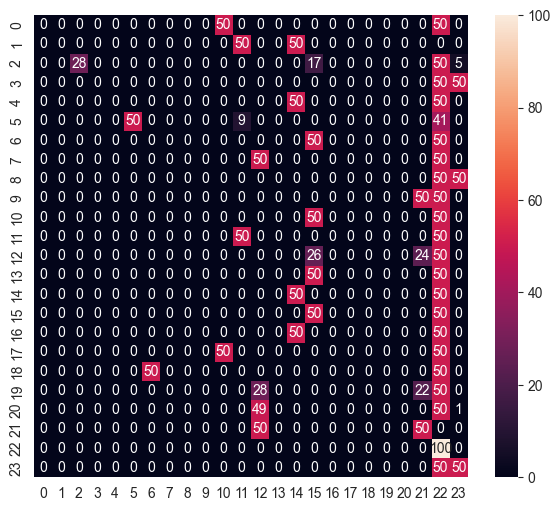

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.00      0.00      0.00       100
           2       1.00      0.28      0.44       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100
           5       1.00      0.50      0.67       100
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00       100
           8       0.00      0.00      0.00       100
           9       0.00      0.00      0.00       100
          10       0.00      0.00      0.00       100
          11       0.46      0.50      0.48       100
          12       0.00      0.00      0.00       100
          13       0.00      0.00      0.00       100
          14       0.25      0.50      0.33       100
          15       0.21      0.50      0.29       100
          16       0.00      0.00      0.00       100
     

C:\thesis\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\thesis\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\thesis\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

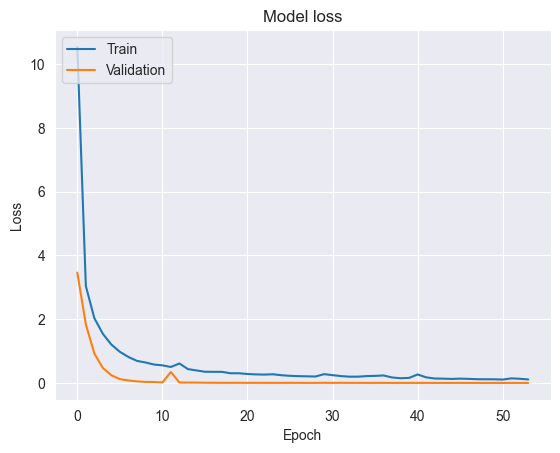

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

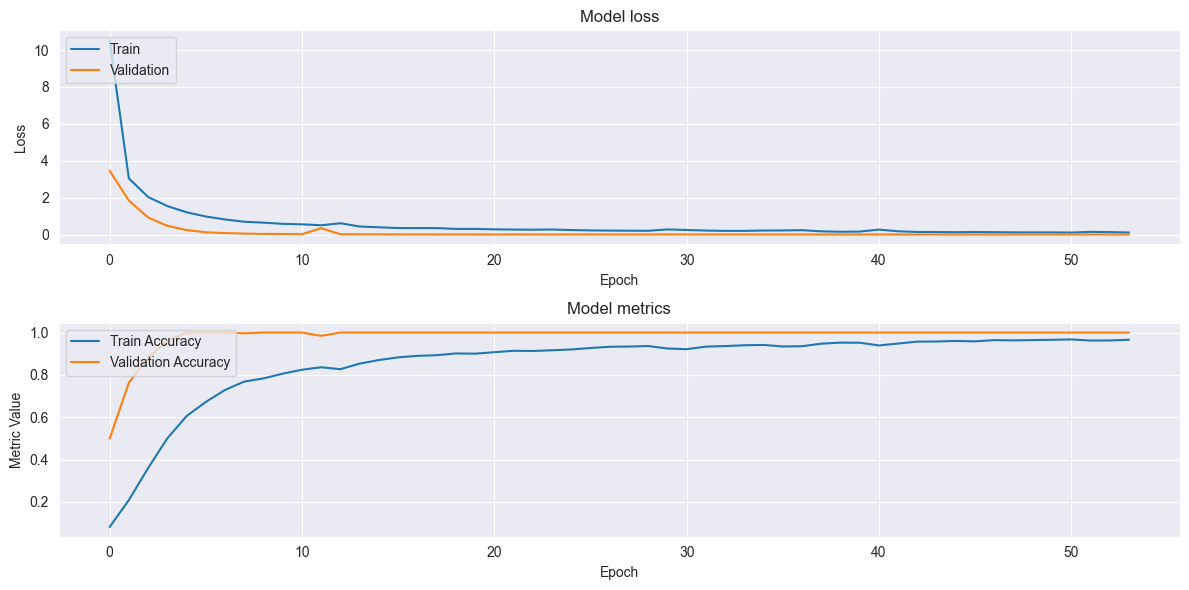

In [30]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy and F1 score values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'F1 Score'], loc='upper left')

plt.tight_layout()
plt.show()

In [31]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define base classifiers
classifier1 = LogisticRegression()
classifier2 = DecisionTreeClassifier()
classifier3 = SVC(probability=True)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

# Create a voting classifier
voting_classifier = VotingClassifier(estimators=[
    ('lr', classifier1),
    ('dt', classifier2),
    ('svc', classifier3)
], voting='hard')  # Change to 'soft' for soft voting

# Train the voting classifier
voting_classifier.fit(X_train, y_train)

# Evaluate the voting classifier
y_pred = voting_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Voting Classifier Accuracy:", accuracy)


Shape of X_train: (13440, 172)
Shape of y_train: (13440,)


C:\thesis\venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier Accuracy: 0.21916666666666668
